Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1255 - val_loss: 0.0840
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0695 - val_loss: 0.0845
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0570 - val_loss: 0.0939
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - val_loss: 0.0897
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0466 - val_loss: 0.0850
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0375 - val_loss: 0.0861
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391 - val_loss: 0.0917
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - val_loss: 0.0912
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.0899
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - val_loss: 0.0950
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - val_loss: 0.0916
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - val_loss: 0.0956
Epoch 13/100


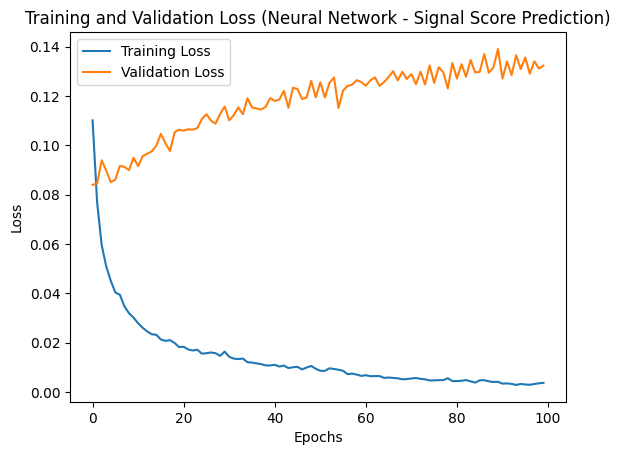

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


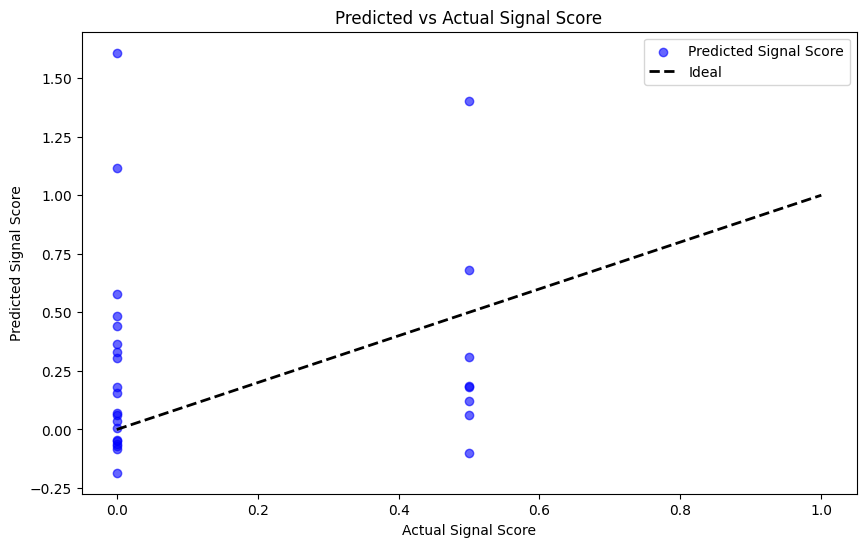

Signal Score model saved as '/Users/samikazi/Desktop/neural_network_signal_score_model.h5' on Desktop.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Paths
image_folder_path = "/Users/samikazi/Desktop/CSE499B/Images/Dhaka"
output_csv = "/Users/samikazi/Desktop/color_percentages.csv"
signal_score_csv = "/Users/samikazi/Desktop/signal_scores.csv"
aqi_data_path = "/Users/samikazi/Desktop/ML Model/CSE499A - Dhaka1.csv"

# Extract color percentages and determine signal scores
with open(signal_score_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image Name", "Red Percentage", "Yellow Percentage", "Green Percentage", "Signal Score"])
    
    for image_name in os.listdir(image_folder_path):
        image_path = os.path.join(image_folder_path, image_name)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Warning: {image_name} could not be loaded.")
            continue
        
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        red_lower, red_upper = np.array([0, 100, 100]), np.array([10, 255, 255])
        yellow_lower, yellow_upper = np.array([20, 100, 100]), np.array([30, 255, 255])
        green_lower, green_upper = np.array([40, 50, 50]), np.array([90, 255, 255])
        
        red_mask = cv2.inRange(hsv_image, red_lower, red_upper)
        yellow_mask = cv2.inRange(hsv_image, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
        
        total_pixels = hsv_image.shape[0] * hsv_image.shape[1]
        red_percentage = (np.sum(red_mask > 0) / total_pixels) * 100
        yellow_percentage = (np.sum(yellow_mask > 0) / total_pixels) * 100
        green_percentage = (np.sum(green_mask > 0) / total_pixels) * 100
        
        # Determine the signal state and assign score
        if green_percentage > red_percentage and green_percentage > yellow_percentage:
            signal_score = 0  # Green signal
        elif red_percentage > green_percentage and red_percentage > yellow_percentage:
            signal_score = 1  # Red signal
        else:
            signal_score = 0.5  # Yellow signal

        # Write to CSV
        writer.writerow([image_name, f"{red_percentage:.2f}", f"{yellow_percentage:.2f}", f"{green_percentage:.2f}", signal_score])

# Load AQI data and signal score data
aqi_data = pd.read_csv(aqi_data_path)
signal_data = pd.read_csv(signal_score_csv)

# Clean AQI data and convert columns to numeric
columns_to_clean = ['PM2.5', 'CO', 'NO2', 'Ozone(O3)', 'PM10', 'SO2']
for col in columns_to_clean:
    aqi_data[col] = aqi_data[col].astype(str).str.replace(',', '.').replace('nan', np.nan).astype(float)

aqi_data.dropna(inplace=True)

# Combine AQI data with signal scores
data = pd.concat([aqi_data.reset_index(drop=True), signal_data[['Signal Score']].reset_index(drop=True)], axis=1)
data.dropna(inplace=True)

# Prepare data for traffic signal score prediction
X_signal = data[['PM2.5', 'CO', 'NO2', 'Ozone(O3)', 'PM10', 'SO2', 'AQI']]
y_signal = data['Signal Score']
X_signal_train, X_signal_test, y_signal_train, y_signal_test = train_test_split(X_signal, y_signal, test_size=0.2, random_state=42)

# Signal Score Prediction Model
scaler = StandardScaler()
X_signal_train_scaled = scaler.fit_transform(X_signal_train)
X_signal_test_scaled = scaler.transform(X_signal_test)
nn_signal_model = Sequential([
    Dense(64, activation='relu', input_dim=X_signal_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1)  # Output one value for Signal Score
])
nn_signal_model.compile(optimizer='adam', loss='mean_squared_error')
signal_history = nn_signal_model.fit(X_signal_train_scaled, y_signal_train, epochs=100, batch_size=10, validation_split=0.2)

# Evaluate and visualize the model performance
# Loss Plot
plt.plot(signal_history.history['loss'], label='Training Loss')
plt.plot(signal_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Neural Network - Signal Score Prediction)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions for the Signal Score Model
signal_pred = nn_signal_model.predict(X_signal_test_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(y_signal_test, signal_pred, color='blue', alpha=0.6, label='Predicted Signal Score')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Signal Score')
plt.ylabel('Predicted Signal Score')
plt.title('Predicted vs Actual Signal Score')
plt.legend()
plt.show()

# Save model
nn_signal_model_filename = '/Users/samikazi/Desktop/neural_network_signal_score_model.h5'
nn_signal_model.save(nn_signal_model_filename)
print(f"Signal Score model saved as '{nn_signal_model_filename}' on Desktop.")
